In [1]:
# Import Libraries
from sklearn import neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN as dbscan
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# load models
import sys
sys.path.append('../')
from database.models import Incidencia, AccidentDBScan, get_db_session, create_db

In [2]:
# with this method we print a raw plot of the incidences
def plot_data(data, labels = 'b', title= 'default'):
    plt.scatter([row[0] for row in data],[row[1] for row in data], c=labels)
    plt.title(title)
    plt.show()

In [3]:
# load the data and plot the data obtained
def load_and_plot_data():
    session = get_db_session('sqlite:///../incidences.db')
    data = session.query(Incidencia.longitud, 
                         Incidencia.latitud).filter(Incidencia.tipo == 'Accidente').all()
    plot_data(data)
    return data

In [4]:
# Apply dbscan algorith to the locations and prints the result
def plot_cluster_data(accident_locations, minimum_points, eps=0.10):
    labels = dbscan(eps=eps, min_samples=minimum_points).fit_predict(accident_locations)
    n_of_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    title = "dbscan: eps:{} Clusters:{}".format(eps, n_of_clusters)
    plot_data(accident_locations, labels, title)
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(np.asarray(data), labels))

In [7]:
# Plot the eps to see the best point to choose
def plot_eps(data):
    dist = neighbors.DistanceMetric.get_metric('euclidean')
    mat_sim = dist.pairwise(data)
    minimum_points = 10

    graph = kneighbors_graph(data, minimum_points, include_self=False)
    array_graph = graph.toarray()
    seq = []
    for i, _ in enumerate(data):
        for j in range(len(data)):
            if array_graph[i][j] != 0:
                seq.append(mat_sim[i][j])
    seq.sort()
    plt.plot(seq)
    plt.show()

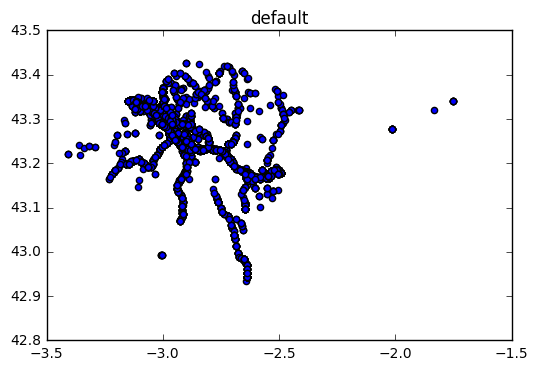

In [8]:
# Load and print raw data
data = load_and_plot_data()

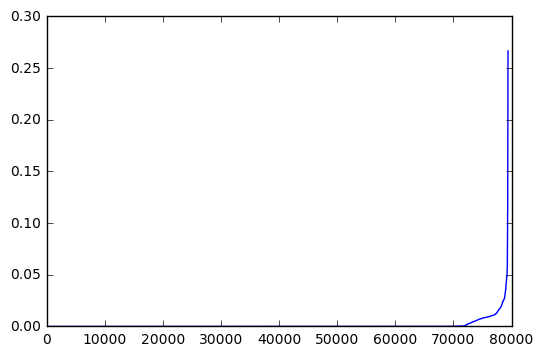

In [9]:
# Plot eps to obtain the best number
plot_eps(data)

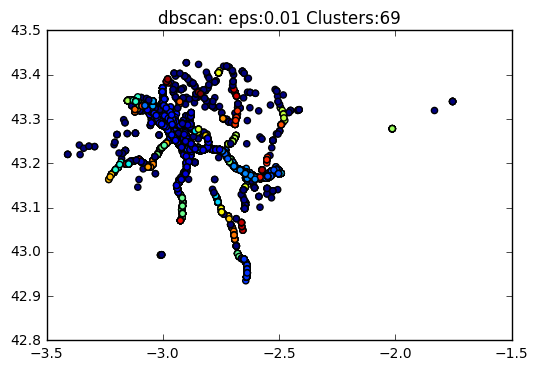

Silhouette Coefficient: 0.117


In [14]:
plot_cluster_data(data, minimum_points=10, eps=0.02)

In [11]:
labels = dbscan(eps=0.01, min_samples=10).fit_predict(data)

array([ 0, 13,  1, ...,  9,  9,  6])

In [8]:
# Now we save the data into a new model
session = get_db_session('sqlite:///../incidences.db')
data = session.query(Incidencia.longitud, 
                     Incidencia.latitud,
                     Incidencia.id).filter(Incidencia.tipo == 'Accidente').all()

for index, label in enumerate(labels):
    accident = AccidentDBScan()
    accident.longitud = data[index][0]
    accident.latitud = data[index][1]
    accident.num_cluster = label
    accident.foreign_accident = data[index][2]
    session.add(accident)

In [9]:
# Save Data
session.commit()